In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import missingno as msno
import scipy as stats
from datetime import datetime

## Data Fields
- datetime - hourly date + timestamp  
- season: 
         - 1 = spring, 
         - 2 = summer, 
         - 3 = fall, 
         - 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather: 
          - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
          - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
          - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
          - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals **(target)**

## Load Data

In [5]:
train_df = pd.read_csv("./train.csv", parse_dates=["datetime"])
test_df = pd.read_csv("./test.csv", parse_dates=["datetime"])

In [6]:
# Check size, shape, columns type
print("train_df size: ", train_df.shape)
print("test_df size: ", test_df.shape)

train_df size:  (10886, 12)
test_df size:  (6493, 9)


In [7]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
train_df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [23]:
train_index = train_df.shape[0]
test_index = test_df.shape[0]
all_df = pd.concat([train_df, test_df]).reset_index()

all_df.drop('index', axis=1, inplace=True)

## Preprocessing

### Feature Engineering

1. datetime $\rightarrow$ "date", "hour", "weekday", "month"
2. "season", "holiday", "workingday", "weather": categorical data (int(og) $\rightarrow$ category)
3. Drop "datetime" column

In [25]:
# datetime -> "date", "hour", "weekday", "month"
all_df["date"] = all_df["datetime"].dt.date
all_df["hour"] = all_df["datetime"].dt.hour
all_df["weekday"] = all_df["datetime"].dt.weekday
all_df["month"] = all_df["datetime"].dt.month
all_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,0,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,3,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,4,5,1


In [27]:
# "season", "holiday", "workingday", "weather" : int -> category
category_var_li = ["season", "holiday", "workingday", "weather"]
for var in category_var_li:
    all_df[var] = all_df[var].astype("category")

all_df.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual               float64
registered           float64
count                float64
date                  object
hour                   int64
weekday                int64
month                  int64
dtype: object

In [30]:
# check missing value
train_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## Visualization

In [29]:
train = all_df[:train_index]
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,0,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,3,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,4,5,1


In [45]:
def changeSeason(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    
train.season = train.month.apply(changeSeason)
train.season = train.season.astype("category")
train.head()

/Users/mkim/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,4,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,0,5,1
1,2011-01-01 01:00:00,4,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,1,5,1
2,2011-01-01 02:00:00,4,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2,5,1
3,2011-01-01 03:00:00,4,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,3,5,1
4,2011-01-01 04:00:00,4,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,4,5,1


,season,count
0,1,501050.0
1,2,648866.0
2,3,596403.0
3,4,339157.0


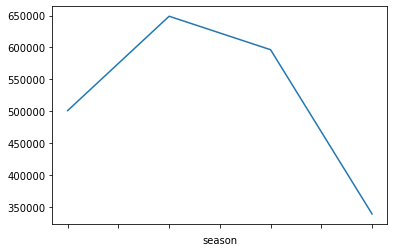

In [52]:
train.groupby(["season"])["count"].sum().plot()
train.groupby("season")["count"].sum().reset_index()

## Time Series
- 수요(count)는 전체적으로 증가하는가? 수요의 추세는 어떻게 되는가?
    - year, month, hour에 따른 수요량
- season에 따라 수요량이 달라지는가?
- holiday에 따른 수요량은 어떻게 되는가?
- weather에 따른 수요량은?

In [68]:
dataTrain = train.copy()
dataTrain["year"] = dataTrain.datetime.dt.year

dataTrain.set_index('datetime', inplace=True)

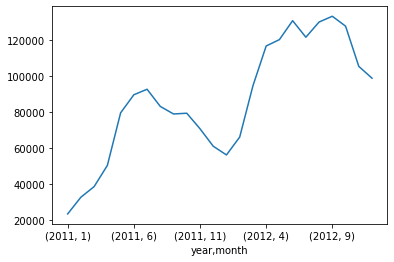

In [69]:
ym_count = dataTrain.groupby(["year", "month"])["count"].sum().reset_index()
dataTrain.groupby(["year", "month"])["count"].sum().plot()

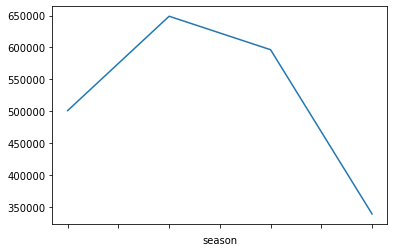

In [70]:
dataTrain.groupby("season")["count"].sum().plot()

In [71]:
# 1, 6칸 밀림 확인
monthly_mean = dataTrain["count"].resample('M').mean()
result = []
result.append(monthly_mean)
for period in range(1, 6):
    temp_mean = monthly_mean.shift(periods=period, fill_value=0)
    temp_mean = temp_mean.rename("{}_monthly_shift".format(period))
    result.append(temp_mean)

result_df = pd.concat(result, axis=1)

result_df

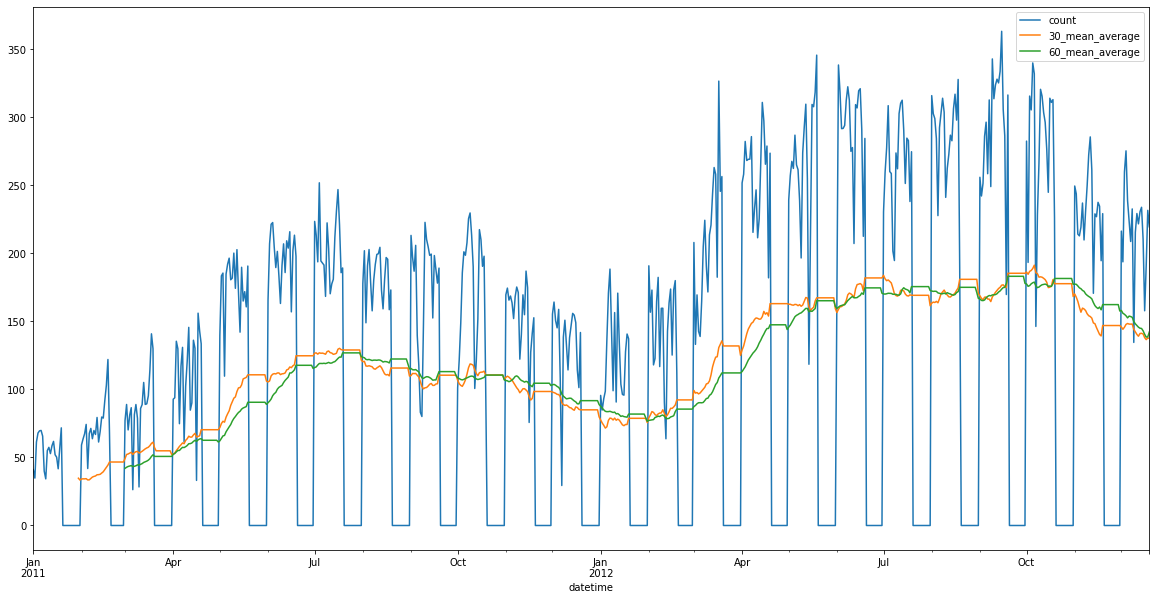

In [88]:
monthly_mean = dataTrain["count"].resample('D').mean().fillna(0)
cumsum_mean = dataTrain["count"].resample('M').mean().cumsum()

monthly_mean_30shift = monthly_mean.rolling(window=30).mean()
monthly_mean_60shift = monthly_mean.rolling(window=60).mean()

df_monthly = pd.DataFrame(monthly_mean, columns=["count"])
df_monthly["30_mean_average"] = monthly_mean_30shift
df_monthly["60_mean_average"] = monthly_mean_60shift

df_monthly.plot(figsize=(20,10))

In [91]:
season_df = dataTrain.groupby("season")["count"].sum().reset_index()
season_df.columns = [["season", "count_sum"]]

,season,count_sum
0,1,501050.0
1,2,648866.0
2,3,596403.0
3,4,339157.0
